Optical Mark Recognition, or OMR for short, is the process of automatically analyzing human-marked documents and interpreting their results.

In [2]:
import cv2
import numpy as np
import imutils

In [3]:
def orderpoints(pts):
    #points in the order of topleft-topright-bottomright-bottomleft
    rect = np.zeros((4,2),dtype="float32")
    sum = np.sum(pts,axis=1)
    rect[0] = pts[np.argmin(sum)]
    rect[2] = pts[np.argmax(sum)]
    diff = np.diff(pts,axis=1)
    rect[3] = pts[np.argmax(diff)]
    rect[1] = pts[np.argmin(diff)]
    return rect
def fourptstransform(image,pts):
    rect = orderpoints(pts)
    
    (tl,tr,br,bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

In [4]:
image = cv2.imread('omr_test_01.png')

In [5]:
while True:
    cv2.imshow('image',image)
    if cv2.waitKey(1) & 0XFF==27:
        break
cv2.destroyAllWindows()

In [7]:
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

In [391]:
edges1 = cv2.Canny(gray,75,200)

In [392]:
blur = cv2.GaussianBlur(gray,(5,5),0)

In [393]:
edges2 = cv2.Canny(blur,75,200)

In [394]:
while True:
    cv2.imshow('edge1',edges1)
    cv2.imshow('edge2',edges2)
    if cv2.waitKey(1) & 0XFF==27:
        break
cv2.destroyAllWindows()

In [13]:
cnts,h = cv2.findContours(edges2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [395]:
for c in cnts:
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,0.02*peri,True)
    if len(approx)==4:
        drawcnts = approx
        break

In [396]:
drawcnts

array([[[131, 206]],

       [[119, 617]],

       [[448, 614]],

       [[430, 208]]], dtype=int32)

In [397]:
draw = drawcnts.ravel()

In [398]:
draw = draw.reshape(4,2)

In [399]:
draw

array([[131, 206],
       [119, 617],
       [448, 614],
       [430, 208]], dtype=int32)

In [400]:
wrap = fourptstransform(image,draw)

In [401]:
while True:
    cv2.imshow('wrap',wrap)
    cv2.imshow('image',image)
    if cv2.waitKey(1) & 0XFF==27:
        break
cv2.destroyAllWindows()

In [402]:
wrap_gray = cv2.cvtColor(wrap,cv2.COLOR_BGR2GRAY)

In [403]:
ret,wrap_thres = cv2.threshold(wrap_gray,145,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

Threshol Otsu will remove the background form our fore ground which helps us to reduce the noise

In [404]:
while True:
    cv2.imshow('wrap',wrap_thres)
    
    if cv2.waitKey(1) & 0XFF==27:
        break
cv2.destroyAllWindows()

In [405]:
contours,h = cv2.findContours(wrap_thres,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [406]:
qpts = []
for c in contours:
    (x,y,w,h) = cv2.boundingRect(c)
    
    ar = w/float(h)
    
    if w>=20 and h>=20 and ar>=0.9 and ar<=1.1:
        qpts.append(c)

We want to basically add circles around our bubble sheet so each bubbles bounding box will be an approximated square so what we do is we actually create an aspect ration and maintain its value in between 0.9 to 1.1 and check for width and height to be sufficenlty large

In [407]:
wrap_thres.shape

(411, 329)

In [408]:
import matplotlib.pyplot as plt

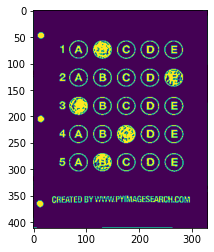

In [409]:
plt.imshow(wrap_thres)

In [410]:
imagecopy = wrap.copy()

In [411]:
for c in qpts:
    cv2.drawContours(imagecopy,c,-1,(0,0,255),3)

In [412]:
while True:
    cv2.imshow('wrap',imagecopy)
    if cv2.waitKey(1) & 0XFF==27:
        break
cv2.destroyAllWindows()

# Sorting the contours

In [424]:
list = []
for i,c in enumerate(qpts):
    M = cv2.moments(c)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    list.append([cx,cy])

In [425]:
list

[[264, 286],
 [219, 286],
 [174, 286],
 [130, 286],
 [84, 286],
 [264, 233],
 [219, 233],
 [174, 233],
 [130, 233],
 [85, 233],
 [264, 180],
 [219, 180],
 [174, 180],
 [130, 180],
 [85, 180],
 [264, 127],
 [219, 127],
 [174, 126],
 [130, 126],
 [85, 126],
 [264, 74],
 [219, 74],
 [174, 74],
 [130, 74],
 [85, 73]]

In [426]:
list = sorted(list,key = lambda l:l[1])

In [427]:
len(list)

25

In [428]:
qpts_sorted = np.array(list)

In [429]:
qpts_sorted = np.expand_dims(qpts_sorted,axis=1)

In [430]:
qpts_sorted.shape

(25, 1, 2)

In [431]:
qpts_sorted = qpts_sorted.reshape(5,5,2)

In [433]:
qpts_sorted

array([[[ 85,  73],
        [264,  74],
        [219,  74],
        [174,  74],
        [130,  74]],

       [[174, 126],
        [130, 126],
        [ 85, 126],
        [264, 127],
        [219, 127]],

       [[264, 180],
        [219, 180],
        [174, 180],
        [130, 180],
        [ 85, 180]],

       [[264, 233],
        [219, 233],
        [174, 233],
        [130, 233],
        [ 85, 233]],

       [[264, 286],
        [219, 286],
        [174, 286],
        [130, 286],
        [ 84, 286]]])

In [434]:
qpts_sorted_copy = qpts_sorted

In [436]:
mylist = []
for i in range(5):
    list = qpts_sorted_copy[i].copy()
    list = sorted(list,key=lambda k:k[0])
    mylist.append(list)

In [437]:
mylist

[[array([85, 73]),
  array([130,  74]),
  array([174,  74]),
  array([219,  74]),
  array([264,  74])],
 [array([ 85, 126]),
  array([130, 126]),
  array([174, 126]),
  array([219, 127]),
  array([264, 127])],
 [array([ 85, 180]),
  array([130, 180]),
  array([174, 180]),
  array([219, 180]),
  array([264, 180])],
 [array([ 85, 233]),
  array([130, 233]),
  array([174, 233]),
  array([219, 233]),
  array([264, 233])],
 [array([ 84, 286]),
  array([130, 286]),
  array([174, 286]),
  array([219, 286]),
  array([264, 286])]]

In [438]:
my_list_arr = np.array(mylist)

In [439]:
my_list_arr

array([[[ 85,  73],
        [130,  74],
        [174,  74],
        [219,  74],
        [264,  74]],

       [[ 85, 126],
        [130, 126],
        [174, 126],
        [219, 127],
        [264, 127]],

       [[ 85, 180],
        [130, 180],
        [174, 180],
        [219, 180],
        [264, 180]],

       [[ 85, 233],
        [130, 233],
        [174, 233],
        [219, 233],
        [264, 233]],

       [[ 84, 286],
        [130, 286],
        [174, 286],
        [219, 286],
        [264, 286]]])

In [440]:
key = []
for i in range(5):
    total = 0
    index = 0
    for j in range(5):
        mask = np.zeros_like(wrap_thres)
        for c in qpts:
            M = cv2.moments(c)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if((cx,cy)==(my_list_arr[i][j][0],my_list_arr[i][j][1])):
                area = M['m00']
                radius = np.sqrt(area/np.pi)
                mask = cv2.circle(mask,(cx,cy),int(radius),255,-1)
                masked = cv2.bitwise_and(wrap_thres,wrap_thres,mask=mask) 
                pixels = cv2.countNonZero(masked)
                #checking the max
                if (pixels>total):
                    total = pixels
                    index = j
    key.append(index)             

In [441]:
key

[1, 4, 0, 2, 1]

In [442]:
ans = [1,4,0,3,1]

In [443]:
score = 0
for i in range(len(key)):
    if key[i]==ans[i]:
        score+=1

In [444]:
final_score = score/len(key)*100

In [445]:
wrap_copy = wrap.copy()

In [446]:
while True:
    cv2.putText(wrap_copy,'score {}%'.format(final_score),(120,20),cv2.FONT_HERSHEY_PLAIN,2,(255,0,0),2)
    cv2.imshow('wrap',wrap_copy)
    if cv2.waitKey(1) & 0XFF==27:
        break
cv2.destroyAllWindows()        